In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn import tree
import copy

In [2]:
def get_phase_name(phaseid, ds_phase_names):
    return ds_phase_names['Phase_englisch'][ds_phase_names['Phase_ID'] == str(phaseid)].values[0]

In [3]:
def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    return lat, lon

In [4]:
def phase_dependent_response(driver_values, t_dev, responses, thresholds):
    #Thresholds are the thresholds in development time where the different growth phases change
    #Responses are the response functions, index starting at 'before the first threshold'
    #driver values are the inputs to the response function
    #t_dev is the (cts) development time
    phase = np.digitize(t_dev, thresholds)
    response = np.zeros(driver_values.shape)
    for phase_index in range(len(responses)):
        response += (phase == phase_index)*responses[phase_index](driver_values) #First brackets indicates if we are at the right phase, second takes the response function for each phase
    return response

In [5]:
def isolate_stage(phen_data, stage):
    return phen_data[phen_data['Name of phase'] == stage]

In [6]:
def time_stage_to_stage(phen_data, stage1, stage2, winter_sowing = False):
    stage1_frame = isolate_stage(phen_data, stage1)
    if winter_sowing: #If the first stage is actually in winter of the previous year, compare the first stage to the year after.
        stage1_frame.loc[:, 'Referenzjahr'] = stage1_frame.loc[:, 'Referenzjahr'] + 1
    stage1_frame.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    stage2_frame = isolate_stage(phen_data, stage2)
    stage2_frame.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    print()
    return (stage2_frame['Eintrittsdatum'] - stage1_frame['Eintrittsdatum'])/ pd.to_timedelta(1, unit='D') #.astype(np.float64)

In [7]:
def interpolate_xy(x, y, ds):
    #Interpolates the input array onto the (non-gridded e.g. phenology station) coordinates x and y.
    #Note hyras is not stored on the full grid, but on some kind of subset. Not quite sure how this works. Just got to hope the stations are in a hyras gridpoint.
    X_for_interp = xr.DataArray(x, dims="modelpoint")
    Y_for_interp = xr.DataArray(y, dims="modelpoint")
    return ds.interp(x=X_for_interp, y=Y_for_interp)#, kwargs={"fill_value": None})

In [8]:
def latlon_to_projection(x_coords, y_coords):
    proj_epsg = ccrs.epsg(3034)
    proj_latlon = ccrs.PlateCarree()
    points_epsg = proj_epsg.transform_points(proj_latlon, x_coords, y_coords)
    x_epsg = points_epsg[:, 0]
    y_epsg = points_epsg[:, 1]
    return x_epsg, y_epsg

In [9]:
def Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
    f_T = np.nan_to_num(f_T)
    return f_T*(T >= T_min)*(T<= T_max)

In [10]:
def Trapezoid_Temp_response(T, T_min, T_opt1, T_opt2, T_max):
    pre_opt = (T>=T_min)*(T<=T_opt1)
    opt = (T>=T_opt1)*(T<=T_opt2)
    post_opt = (T>=T_opt2)*(T<=T_max)
    return pre_opt*(T - T_min)/(T_opt1 - T_min) + opt + post_opt*(T_max - T)/(T_max - T_opt2)

In [84]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')

    def __init__(self, address):
        self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            self.phen_data = self.phen_data.drop(drop_name, axis = 1)
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = get_phase_name(phaseid, self.phase_names)

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        LAT, LON = get_station_locations(self.phen_data, self.station_data)
        self.phen_data['lat'] = LAT
        self.phen_data['lon'] = LON
        self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)

    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def make_input_array(self):
        just_emergence_phen_data = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        just_emergence_phen_data = just_emergence_phen_data.where(just_emergence_phen_data['Eintrittsdatum'] > np.datetime64('2005-01-01')).dropna()
        x_coords = just_emergence_phen_data['lon'].values
        y_coords = just_emergence_phen_data['lat'].values
        #Makes an array to put into GDD model
        print('project to new coords')
        x_epsg, y_epsg = latlon_to_projection(x_coords, y_coords)
        print('interpolate driver to station locations')
        self.GDD_driver_data = interpolate_xy(x_epsg, y_epsg, self.T_mean)
        self.GDD_driver_data['emergence_dates'] = (("modelpoint"), just_emergence_phen_data['Eintrittsdatum'].values)
        self.GDD_driver_data['Stations_id'] = (("modelpoint"), just_emergence_phen_data['Stations_id'].values)
        self.GDD_driver_data['Referenzjahr'] = (("modelpoint"), just_emergence_phen_data['Referenzjahr'].values)
        self.GDD_driver_data = self.GDD_driver_data.assign_coords(modelpoint=np.arange(self.GDD_driver_data.sizes['modelpoint']))
    
    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        if type(self.GDD_driver_data) == str:
            print('Make a dataset for the driving variable first')
        else:
            t_dev = np.zeros(self.GDD_driver_data[driver_variable].isel(time=0).values.shape) #Continuous development time. When this passes through some thresholds then have change in phase.
            dev_time_series = [t_dev.copy()]
            i_day = self.GDD_driver_data['emergence_dates'].values.copy()
            i_day = i_day + np.timedelta64(12, 'h') #so that times are at midday rather than midnight
            time_indexer = xr.DataArray(i_day, dims=["modelpoint"])
            #self.GDD_driver_data.sel(time=time_indexer, method='nearest')
            for day_count in range(365):#while np.sum(t_dev < maturity_t_dev) > 0.05*len(ds_driver['modelpoint']):
                #print(day_count)
                driver_values = self.GDD_driver_data.sel(time=time_indexer, method='nearest')[driver_variable].values
                #print(len(driver_values[t_dev<maturity_t_dev]))
                t_dev += response(driver_values, t_dev) #Rate of change of development stage
                dev_time_series.append(t_dev.copy())
                i_day += np.timedelta64(1,'D')
            self.model_dev_time_series = np.array(dev_time_series)

    def get_phase_dates(self, thresholds):
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:, obs_index]) #Note that the thresholds are NOT the bins for numpy digitize!
    
    def get_modelled_dataset(self, phase_list = []):
        if len(phase_list) == 0:
            computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(self.phase_dates_array.shape[0])]
        else:
            computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
            #Initialize dataset for comparison with station IDs and years
        data_comparison = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values),
                        }
        self.ds_comparison = pd.DataFrame(data_comparison)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(computed_phases):
            self.ds_comparison[phase] = self.phase_dates_array[phase_index, :]
        self.ds_comparison.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, phase_list):
        observed_to_first_stage = time_stage_to_stage(self.phen_data, 'beginning of emergence', phase_list[0]).dropna()
        self.ds_observed = pd.DataFrame({f'observed time emergence to {phase_list[0]}': observed_to_first_stage})
        for phase in phase_list[1:]:
            self.ds_observed[f'observed time emergence to {phase}'] = time_stage_to_stage(self.phen_data, 'beginning of emergence', phase).dropna()
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.concat([self.ds_comparison, self.ds_observed], axis = 1)
        
    def get_driver_data_for_ML(self, driver_variable, predictor_days = 200):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(predictor_days)]) #so that times are at midday rather than midnight
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.data_for_ML = self.GDD_driver_data.sel(time=time_indexer, method='nearest')
        y_data = {}
        for phase_time in self.ds_observed.columns:
            y_data[phase_time] = (['modelpoint'], self.ds_observed[phase_time].values)
        obs_data = xr.Dataset(data_vars = y_data,
                              coords = {'Referenzjahr':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(1))),
                                        'Stations_id':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(0)))}
                                        )
        obs_data = obs_data.set_xindex(['Referenzjahr', 'Stations_id'])
        self.data_for_ML = self.data_for_ML.reset_index('modelpoint')
        self.data_for_ML['Stations_id'] = self.data_for_ML['Stations_id'].astype(np.int64)
        self.data_for_ML['Referenzjahr'] = self.data_for_ML['Referenzjahr'].astype(np.int64)
        self.data_for_ML = self.data_for_ML.set_coords(['Referenzjahr', 'Stations_id'])
        self.data_for_ML = self.data_for_ML.set_xindex(['Referenzjahr', 'Stations_id'])
        self.data_for_ML = xr.merge([self.data_for_ML, obs_data], join='left')#[driver_variable]
        self.data_for_ML = self.data_for_ML.dropna('modelpoint')
        
    def get_X_y_for_ML(self, driver_variable):
        self.X_for_ML = self.data_for_ML.dropna('modelpoint')[driver_variable].values.T
        self.y_for_ML = np.array([self.data_for_ML.dropna('modelpoint')[phase_time].values for phase_time in self.ds_observed.columns]).T
    
    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.data_for_ML['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.data_for_ML['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.data_for_ML['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.data_for_ML['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, phase_list, md=20):
        regr = tree.DecisionTreeRegressor(max_depth=md)
        fit = regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.data_for_ML['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.data_for_ML['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.data_for_ML['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.data_for_ML['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results.drop_duplicates(), self.ds_comparison, self.ds_observed], axis = 1)
        
        


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1892\709899038.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [85]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.order_phen_dataset()
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.add_locations()
Maize_set.make_input_array()
resps = [lambda x: Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: Wang_Engel_Temp_response(x, 0, 33, 44)]
thresholds = [45, 65]
Maize_set.dev_under_response(lambda x, y: phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.get_observed_dataset(phase_list=['beginning of flowering', 'yellow ripeness'])
Maize_set.get_modelled_dataset(phase_list=['beginning of flowering', 'yellow ripeness'])
Maize_set.compare_modelled_observed()
Maize_set.get_driver_data_for_ML('tas')
Maize_set.get_X_y_for_ML('tas')

project to new coords
interpolate driver to station locations


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_1892\2397755492.py:3: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


In [86]:
Maize_set.subsample_X_y()
Maize_set.decision_tree(['beginning of flowering', 'yellow ripeness'])
Maize_set.ML_modelled_observed()

In [88]:
Maize_set.ds_modelled_observed.dropna()

Training  \
Stations_id Referenzjahr            
7504        2007            False   
            2008            False   
            2009            False   
            2010            False   
7521        2015            False   
...                           ...   
10306       2010             True   
10810       2008             True   
10288       2009             True   
8584        2008             True   
10541       2021             True   

                          ML prediction emergence to beginning of flowering  \
Stations_id Referenzjahr                                                      
7504        2007                                                  82.000000   
            2008                                                  74.000000   
            2009                                                 101.000000   
            2010                                                  75.000000   
7521        2015                                                  81.736842   
...                                                                     ...   
10306       2010                                                  67.250000   
10810       2008                                                  81.000000   
10288       2009                                                  70.000000   
8584        2008                                                  71.333333   
10541       2021                                                  69.958333   

                          ML check obs to beginning of flowering  \
Stations_id Referenzjahr                                           
7504        2007                                            80.0   
            2008                                            77.0   
            2009                                            83.0   
            2010                                            71.0   
7521        2015                                            76.0   
...                                                          ...   
10306       2010                                            68.0   
10810       2008                                            81.0   
10288       2009                                            68.0   
8584        2008                                            67.0   
10541       2021                                            73.0   

                          ML prediction emergence to yellow ripeness  \
Stations_id Referenzjahr                                               
7504        2007                                          124.000000   
            2008                                          135.000000   
            2009                                          117.000000   
            2010                                          121.000000   
7521        2015                                          132.263158   
...                                                              ...   
10306       2010                                          113.875000   
10810       2008                                          117.000000   
10288       2009                                          113.500000   
8584        2008                                          119.666667   
10541       2021                                          118.200000   

                          ML check obs to yellow ripeness  \
Stations_id Referenzjahr                                    
7504        2007                                    145.0   
            2008                                    147.0   
            2009                                    126.0   
            2010                                    140.0   
7521        2015                                    143.0   
...                                                   ...   
10306       2010                                    114.0   
10810       2008                                    117.0   
10288       2009                                    112.0   
8584        2008      

In [91]:
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.boxplot([ds[f'modelled time emergence to {phase}'].dropna(), ds[f'ML prediction emergence to {phase}'].dropna(), ds[f'observed time emergence to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase}', f'ML prediction emergence to\n{phase}', f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

        #fig, ax = plt.subplots(figsize = (10, 10))
        #ax.boxplot((ds[f'modelled time emergence to {phase}']- ds[f'observed time emergence to {phase}']).dropna(), 
        #           tick_labels=[f'diff modelled/observed time emergence\nto{phase}'], 
        #           widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        #plt.xticks(rotation = 90)
        #ax.tick_params(labelsize = font_size)
        #ax.set_title(f'Difference between modelled\nand observed times to {phase}', fontsize = font_size)
        #ax.set_ylabel('Time (days)', fontsize = font_size)
        #fig.savefig(f'plots/modelled_observed_{phase}_diffs.png', bbox_inches='tight')

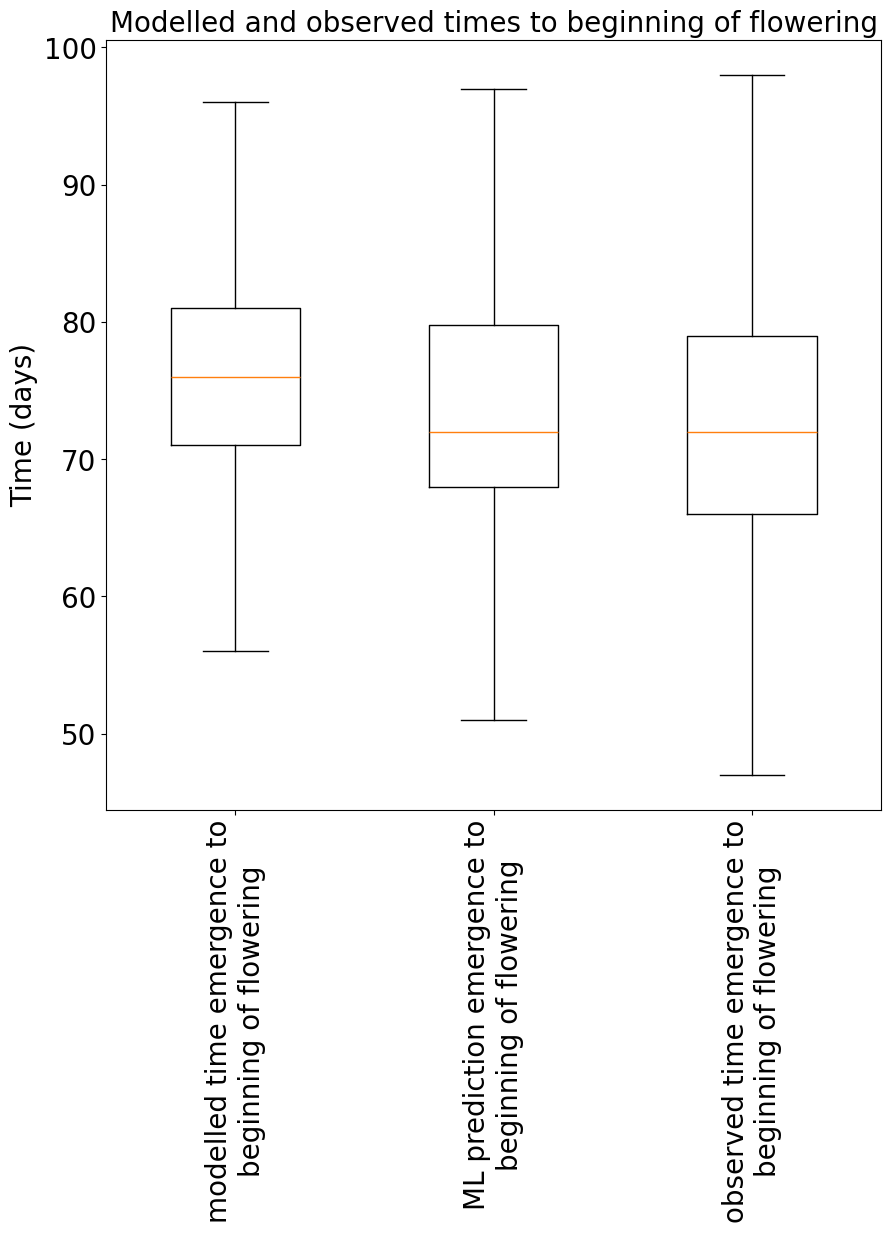

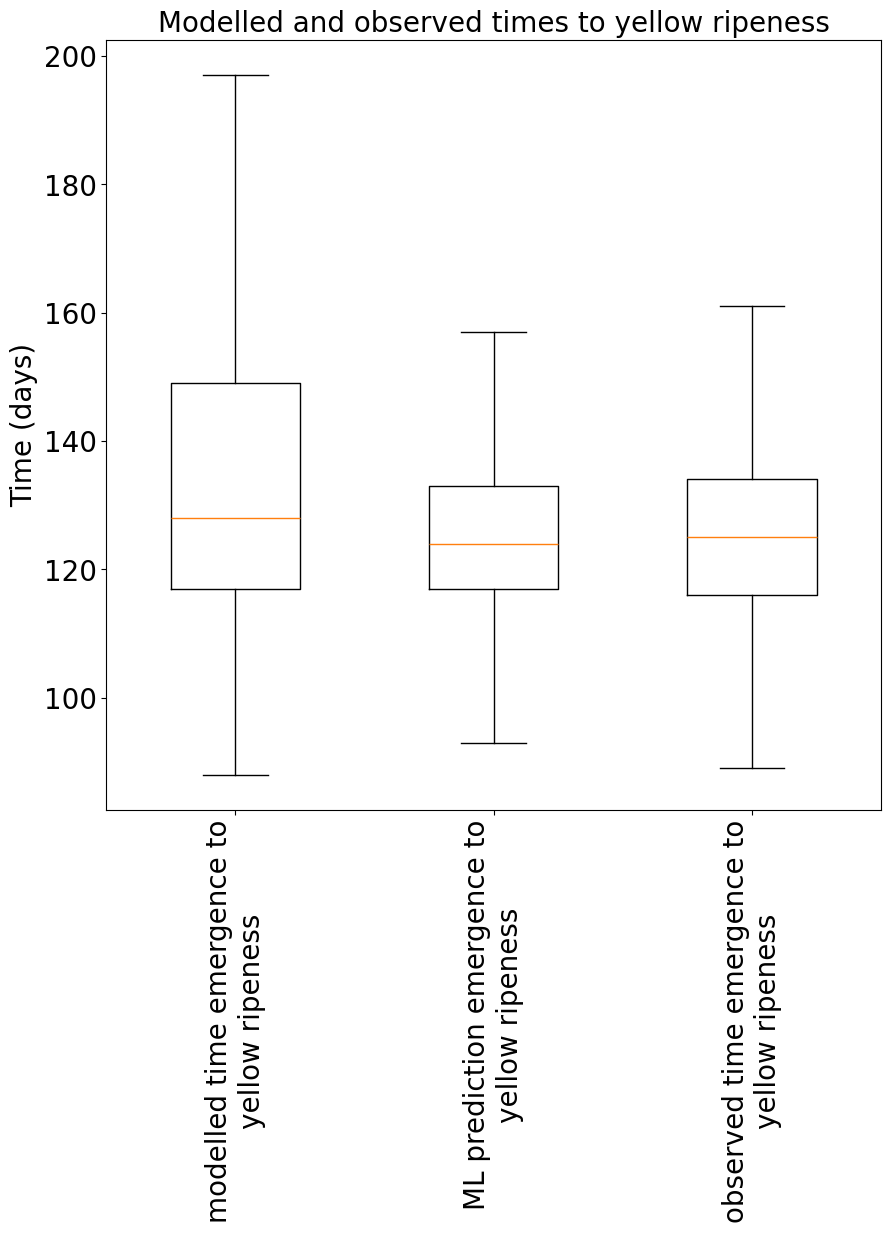

In [92]:
box_plot_modelled_observed(Maize_set.ds_modelled_observed, ['beginning of flowering', 'yellow ripeness'])

In [74]:
ds_ML_results = pd.concat([Maize_set.ds_ML_predictions_verification, Maize_set.ds_ML_predictions_training], axis=0)
ds_ML_results.set_index(['Stations_id', 'Referenzjahr'], inplace=True)

In [77]:
pd.concat([ds_ML_results.drop_duplicates(), Maize_set.full_dataset.drop_duplicates()], axis=1).dropna()
#Maize_set.full_dataset.drop_duplicates()[Maize_set.full_dataset.drop_duplicates().duplicated()]
#ds_ML_results.drop_duplicates()[ds_ML_results.drop_duplicates().duplicated()]
#Maize_set.full_dataset

Training  \
Stations_id Referenzjahr            
7504        2009            False   
            2010            False   
7521        2018            False   
            2020            False   
            2022            False   
...                           ...   
10564       2010             True   
10403       2007             True   
15005       2011             True   
12860       2005             True   
7943        2020             True   

                          ML prediction emergence to beginning of flowering  \
Stations_id Referenzjahr                                                      
7504        2009                                                       65.0   
            2010                                                       73.0   
7521        2018                                                       79.0   
            2020                                                       82.0   
            2022                                                       81.0   
...                                                                     ...   
10564       2010                                                       75.0   
10403       2007                                                       89.0   
15005       2011                                                       63.0   
12860       2005                                                       70.0   
7943        2020                                                       77.0   

                          ML check obs to beginning of flowering  \
Stations_id Referenzjahr                                           
7504        2009                                            83.0   
            2010                                            71.0   
7521        2018                                            63.0   
            2020                                            91.0   
            2022                                            75.0   
...                                                          ...   
10564       2010                                            75.0   
10403       2007                                            89.0   
15005       2011                                            63.0   
12860       2005                                            70.0   
7943        2020                                            77.0   

                          ML prediction emergence to yellow ripeness  \
Stations_id Referenzjahr                                               
7504        2009                                               110.0   
            2010                                               139.0   
7521        2018                                               105.0   
            2020                                               139.0   
            2022                                               141.0   
...                                                              ...   
10564       2010                                                96.0   
10403       2007                                               145.0   
15005       2011                                               137.0   
12860       2005                                               134.0   
7943        2020                                               105.0   

                          ML check obs to yellow ripeness  \
Stations_id Referenzjahr                                    
7504        2009                                    126.0   
            2010                                    140.0   
7521        2018                                    108.0   
            2020                                    166.0   
            2022                                    122.0   
...                                                   ...   
10564       2010                                     96.0   
10403       2007                                    145.0   
15005       2011                                    137.0   
12860       2005      

In [43]:
regr1 = tree.DecisionTreeRegressor(max_depth=10)
regr2 = tree.DecisionTreeRegressor(max_depth=20)
regr3 = tree.DecisionTreeRegressor(max_depth=40)
fit1 = regr1.fit(Maize_set.subsample_X, Maize_set.subsample_y)
fit2 = regr2.fit(Maize_set.subsample_X, Maize_set.subsample_y)
fit3 = regr3.fit(Maize_set.subsample_X, Maize_set.subsample_y)

In [48]:
fit3.predict(Maize_set.verification_X)

array([[ 65., 110.],
       [ 73., 139.],
       [ 79., 105.],
       ...,
       [ 73., 141.],
       [ 85., 144.],
       [ 79., 121.]])

In [ ]:
def get_ML_dataset(self, phase_list = []):
    if len(phase_list) == 0:
        computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(self.phase_dates_array.shape[0])]
    else:
        computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
        #Initialize dataset for comparison with station IDs and years
    data_comparison = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values),
                    'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values),
                    }
    self.ds_comparison = pd.DataFrame(data_comparison)
    #Add modelled phase dates etc. to the comparison set.
    ML_e
    for phase_index, phase in enumerate(computed_phases):
        self.ds_comparison[phase] = self.ML_fit[phase_index, :]
    self.ds_comparison.set_index(['Stations_id', 'Referenzjahr'], inplace=True)

In [ ]:
box_plot_modelled_observed(Maize_set.full_dataset, ['beginning of flowering', 'yellow ripeness'])

In [18]:
flowering_obs = xr.Dataset(data_vars = {'observed time emergence to beginning of flowering':(['modelpoint'], Maize_set.ds_observed['observed time emergence to beginning of flowering'].values)},
                           coords = {'Referenzjahr':(['modelpoint'], np.int64(Maize_set.ds_observed.index.get_level_values(1))),
                                     'Stations_id':(['modelpoint'], np.int64(Maize_set.ds_observed.index.get_level_values(0)))}
)
Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.reset_index('modelpoint')
Maize_set.GDD_driver_data['Stations_id'] = Maize_set.GDD_driver_data['Stations_id'].astype(np.int64)
Maize_set.GDD_driver_data['Referenzjahr'] = Maize_set.GDD_driver_data['Referenzjahr'].astype(np.int64)
Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.set_coords(['Referenzjahr', 'Stations_id'])
Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.set_xindex(['Referenzjahr', 'Stations_id'])
flowering_obs = flowering_obs.set_xindex(['Referenzjahr', 'Stations_id'])
ds = xr.merge([Maize_set.GDD_driver_data['tas'], flowering_obs], join='left')
#Maize_set.GDD_data_for_ML['tas'].values.shape
## NOTE FOR SCIKIT LEARN AXIS 0 GIVES THE LIST OF EXAMPLES ##

In [55]:
def get_X_for_ML(phenset, driver_variable, predictor_days = 200):
    i_day = phenset.GDD_driver_data['emergence_dates'].values.copy()
    i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(predictor_days)]) #so that times are at midday rather than midnight
    time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
    phenset.GDD_data_for_ML = phenset.GDD_driver_data.sel(time=time_indexer, method='nearest')
    for variable in phenset.ds_observed.columns:
        
    #phenset.GDD_data_for_ML = xr.concat([phenset.GDD_data_for_ML, phenset.ds_observed], dim)
    #phenset.X_for_ML = phenset.GDD_data_for_ML[driver_variable].values.T

SyntaxError: incomplete input (2514688534.py, line 9)

In [19]:
ds

<xarray.Dataset>
Dimensions:                                            (time: 25568,
                                                        modelpoint: 13608)
Coordinates:
  * time                                               (time) datetime64[ns] ...
  * modelpoint                                         (modelpoint) object MultiIndex
  * Referenzjahr                                       (modelpoint) int64 200...
  * Stations_id                                        (modelpoint) int64 750...
    lon                                                (modelpoint) float64 1...
    lat                                                (modelpoint) float64 5...
    x                                                  (modelpoint) float64 4...
    y                                                  (modelpoint) float64 3...
Data variables:
    tas                                                (time, modelpoint) float64 ...
    observed time emergence to beginning of flowering  (modelpoint) float64 1...
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Mean Air Temperature
    units:              Celsius
    grid_mapping:       crs_HYRAS
    cell_methods:       time: mean
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ETRS_1989",DATUM["...

In [41]:
S = 7504
Y = 2005
print(ds['tas'].sel(Referenzjahr=Y, Stations_id = S).values, Maize_set.GDD_driver_data['tas'].sel(Referenzjahr=Y, Stations_id = S).values)
print(ds.sel(Referenzjahr=Y, Stations_id = S)['observed time emergence to beginning of flowering'].values, Maize_set.ds_observed.loc[(S, Y)]['observed time emergence to beginning of flowering'])

[-2.26627311 -0.26627314  0.30000001 ...  2.14231484  4.09141191
  3.53372684] [-2.26627311 -0.26627314  0.30000001 ...  2.14231484  4.09141191
  3.53372684]
100.0 100.0


In [27]:
Maize_set.ds_observed.loc[(7504, 1999)]

observed time emergence to beginning of flowering     64.0
observed time emergence to yellow ripeness           115.0
Name: (7504, 1999), dtype: float64

In [34]:
ds['tas']

<xarray.DataArray 'tas' (time: 25568, modelpoint: 13608)>
array([[-2.26627311, -2.26627311, -2.26627311, ..., -0.2940199 ,
        -0.2940199 , -0.2940199 ],
       [-0.26627314, -0.26627314, -0.26627314, ...,  0.64216827,
         0.64216827,  0.64216827],
       [ 0.30000001,  0.30000001,  0.30000001, ...,  0.52608413,
         0.52608413,  0.52608413],
       ...,
       [ 2.14231484,  2.14231484,  2.14231484, ...,  1.8898959 ,
         1.8898959 ,  1.8898959 ],
       [ 4.09141191,  4.09141191,  4.09141191, ...,  2.32608407,
         2.32608407,  2.32608407],
       [ 3.53372684,  3.53372684,  3.53372684, ...,  1.33663196,
         1.33663196,  1.33663196]])
Coordinates:
  * time          (time) datetime64[ns] 1951-01-01T12:00:00 ... 2020-12-31T12...
  * modelpoint    (modelpoint) object MultiIndex
  * Referenzjahr  (modelpoint) int64 2005 2007 2008 2009 ... 2017 2018 2019 2022
  * Stations_id   (modelpoint) int64 7504 7504 7504 7504 ... 19914 19914 19914
    lon           (modelpoint) float64 10.05 10.05 10.05 ... 9.363 9.363 9.363
    lat           (modelpoint) float64 54.32 54.32 54.32 ... 50.32 50.32 50.32
    x             (modelpoint) float64 4.003e+06 4.003e+06 ... 3.956e+06
    y             (modelpoint) float64 3.049e+06 3.049e+06 ... 2.619e+06
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Mean Air Temperature
    units:              Celsius
    grid_mapping:       crs_HYRAS
    cell_methods:       time: mean
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ETRS_1989",DATUM["...